# ML Classification - Network Traffic Analysis
## Part 2 - DATA PROCESSING

In this notebook, we load the cleaned dataset file and process it into an acceptable format to ML algorithms.

> **INPUT:** the cleaned dataset csv file as resulted from the previous cleaning phase.<br>
> **OUTPUT:** a processed (final version) of the dataset as a csv file.  

***

### 1. INITIALIZATION

In [5]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Set display options
pd.set_option('display.max_columns', None)

### 2. LOADING CLEANED DATASET

#### Reading dataset file into pandas DataFrame

In [8]:
# Initialize required variables to read the cleaned data file
data_file_location = "..\\data\\interim\\"
data_file_name = "conn.log.labeled_cleaned"
data_file_ext = ".csv"

# Read the dataset
data_df = pd.read_csv(data_file_location + data_file_name + data_file_ext, index_col=0)

#### Exploring dataset summary and statistics

In [9]:
# Check dataset shape
data_df.shape

(23145, 17)

In [10]:
# Check dataset head
data_df.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.195,41040,185.244.25.235,80,tcp,NaN,3.139211,0.0,0.0,S0,0,S,3,180,0,0,Benign
1,192.168.1.195,41040,185.244.25.235,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign
2,192.168.1.195,41040,185.244.25.235,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign
3,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149.0,128252.0,SF,2896,ShADadttcfF,94,5525,96,139044,Benign
4,192.168.1.195,41042,185.244.25.235,80,tcp,NaN,3.147116,0.0,0.0,S0,0,S,3,180,0,0,Benign


In [11]:
# Check dataset summary
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23145 entries, 0 to 23144
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_h      23145 non-null  object 
 1   id.orig_p      23145 non-null  int64  
 2   id.resp_h      23145 non-null  object 
 3   id.resp_p      23145 non-null  int64  
 4   proto          23145 non-null  object 
 5   service        1847 non-null   object 
 6   duration       5321 non-null   float64
 7   orig_bytes     5321 non-null   float64
 8   resp_bytes     5321 non-null   float64
 9   conn_state     23145 non-null  object 
 10  missed_bytes   23145 non-null  int64  
 11  history        23145 non-null  object 
 12  orig_pkts      23145 non-null  int64  
 13  orig_ip_bytes  23145 non-null  int64  
 14  resp_pkts      23145 non-null  int64  
 15  resp_ip_bytes  23145 non-null  int64  
 16  label          23145 non-null  object 
dtypes: float64(3), int64(7), object(7)
memory usage: 3.2+ M

### 3. DATA PREPROCESSING

#### Analyzing target attribute

In [12]:
# Check null values in the target attribute
data_df["label"].isna().sum()

0

In [13]:
# Check values distribution
data_df["label"].value_counts()

label
Malicious    21222
Benign        1923
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

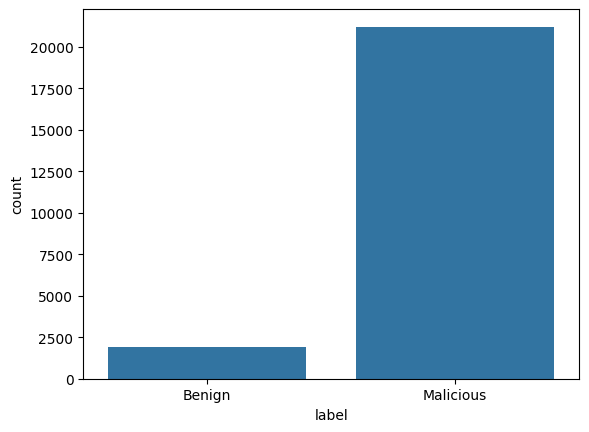

In [14]:
# Plot target attribute on a count plot
sns.countplot(data=data_df, x="label")

- As we can see from these statistics, the target attribute is highly imbalanced.
- We will maintain the original distribution for now until we explore the models' performance. 
- Suitable techniques will be applied to re-balance the labels if we couldn't achieve an acceptable prediction accuracy. 

#### Encoding target attribute

In [15]:
# Initialize encoder with default parameters
target_le = LabelEncoder()

# Fit the encoder to the target attribute
encoded_attribute = target_le.fit_transform(data_df["label"])

# Replace target attribute with encoded values
data_df["label"] = encoded_attribute

# Check mapped labels
dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))

{'Benign': 0, 'Malicious': 1}

#### Handling outliers

In [16]:
# Use describe() method to obtain general statistics about the numerical features
numerical_features = ["duration", "orig_bytes",	"resp_bytes", "missed_bytes", "orig_pkts",	"orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]
data_df[numerical_features].describe()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,5321.000000,5.321000e+03,5321.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,22.806503,1.478868e+04,350.429431,2.127112,6.375157,3.664312e+03,0.611017,111.218967
std,722.522302,1.036441e+06,5378.262771,102.490787,178.548725,5.003762e+05,8.305898,2713.082822
min,0.000497,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.075814,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,3.110974,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,3.153695,6.200000e+01,243.000000,0.000000,1.000000,7.600000e+01,0.000000,0.000000
max,48976.819063,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000


- In a quick reading of the statistical summary, we noticed many features with values that can be seen as outliers. 
- It's fairly difficult to confirm such values and their actual reasons without proper explanations by experts in the corresponding domain.
- For the sake of this demo, we will treat only "duration" as a feature with actual outliers as it's the only feature with a significant amount of unique values.

<Axes: ylabel='duration'>

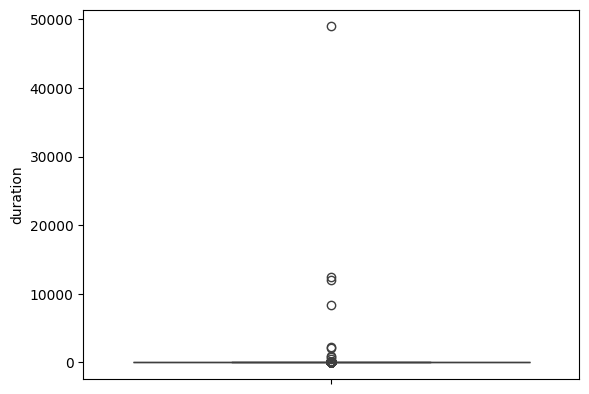

In [17]:
# Plot "duration" feature on a boxplot
sns.boxplot(data=data_df, y="duration")

In [18]:
# Replace outliers using IQR (Inter-quartile Range)
outliers_columns = ['duration']
for col_name in outliers_columns:
    # Calculate first and third quartiles
    q1, q3 = np.nanpercentile(data_df[col_name],[25,75])
    
    # Calculate the inter-quartile range
    intr_qr = q3-q1

    # Calculate lower and higher bounds
    iqr_min_val = q1-(1.5*intr_qr)
    iqr_max_val = q3+(1.5*intr_qr)
    print(f"(min,max) bounds for \"{col_name}\": ({iqr_min_val},{iqr_max_val})")
    
    # Replace values that are less than min or larger then max with np.nan
    data_df.loc[data_df[col_name] < iqr_min_val, col_name] = np.nan
    data_df.loc[data_df[col_name] > iqr_max_val, col_name] = np.nan

(min,max) bounds for "duration": (0.4589924999999997,4.7705165)


In [19]:
# Reevaluate the new distribution of values
data_df["duration"].describe()

count    3718.000000
mean        2.848130
std         0.806614
min         0.553685
25%         3.085004
50%         3.110717
75%         3.140398
max         4.723553
Name: duration, dtype: float64

#### Encoding IP addresses

Some columns contain IP addresses that need to be encoded into a corresponding numeric format.

In [20]:
# A method to encode an ip address using the IPv4/IPv6 manipulation library
def encode_ipv4(ip):
    return int(ipaddress.IPv4Address(ip))

In [21]:
# Encode ip features into numerical values
data_df["id.orig_h"] = data_df["id.orig_h"].apply(encode_ipv4)
data_df["id.resp_h"] = data_df["id.resp_h"].apply(encode_ipv4)

In [22]:
# Check encoded ip addresses
ip_columns = ["id.orig_h","id.resp_h"]
for c in ip_columns:
    print(f"IP col ({c}) values: {data_df[c].unique()}")

IP col (id.orig_h) values: [3232235971 3232235777]
IP col (id.resp_h) values: [3119782379 2481415173 3278999753 1383150888 1359149245 1507709628
 3232235971 1359150816 3232235777 3266728169 1403518070 3563102355
 3247836863 1296985084  522144291 1843416203  633038892 1315727085
 1372076301 1359007963 2482712716 1359150624 3642641299 3116200853
  773615348 1585212350 1383150884  773614874 1507709998   83966075
 1347361135  631095852 1508837990 1507710594 1358024824 1354654157
 1760474084 1352111981 1111702952   16843009  842150453 2297672069
 2892123595 2449481872 1383150883 3272968657 2067517881 1247507960
 1195197076]


#### Handling missing values

In [23]:
# Check the number of null values in each column
data_df.isnull().sum().sort_values(ascending=False)

service          21298
duration         19427
resp_bytes       17824
orig_bytes       17824
missed_bytes         0
resp_ip_bytes        0
resp_pkts            0
orig_ip_bytes        0
orig_pkts            0
history              0
id.orig_h            0
conn_state           0
id.orig_p            0
proto                0
id.resp_p            0
id.resp_h            0
label                0
dtype: int64

<Axes: >

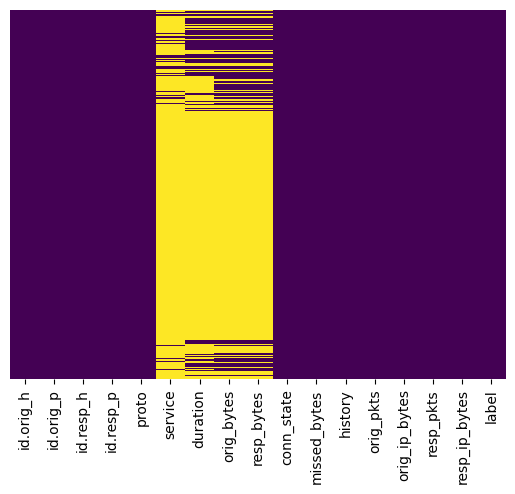

In [24]:
# Check null values using heatmap
sns.heatmap(data=data_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

- There are only 4 columns with a lot of missing values, one categorical ("service) and three numerical ("duration", "orig_bytes", "resp_bytes").
- One possible approach is to entirely discard these columns from the dataset. 
- Instead, we will try to impute their values to preserve any hidden information and check if we can obtain better prediction performance.

##### Impute missing values: categorical features

<Axes: xlabel='label', ylabel='count'>

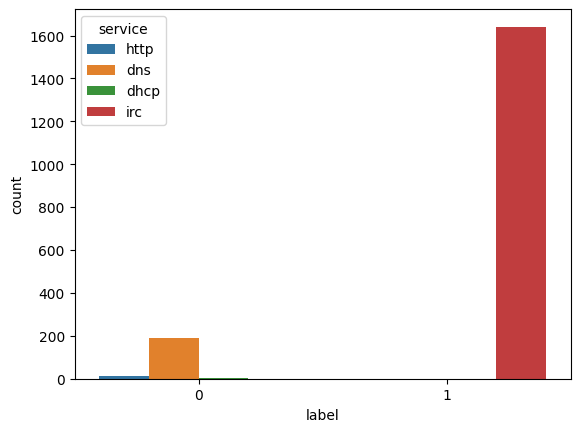

In [25]:
# Check the relationship between the "service" and the target attribute
sns.countplot(data=data_df, x="label", hue="service")

- Due to this visualization, almost all *Malicious* observations belong to a specific service type ("irc"), while the other 3 types represent *Benign* samples.
- Accordingly, although "service" feature has high number of missing values, it has a strong correlation with the target attribute.
- The decision here is to keep "service" attribute while trying to impute its missing values using another classifier. 

In [26]:
# Select specific columns to be used for the classification, here we initially select the numerical attributes with no missing values.
srv_training_columns = ["id.orig_h","id.orig_p","id.resp_h","id.resp_p","missed_bytes","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes"] 

# Split the rows into two datasets containing rows with/without "service"
data_df_with_service = data_df[data_df["service"].notna()]
data_df_no_service = data_df[data_df["service"].isna()]

# Split the service dataset into dependent and independent features
srv_X = data_df_with_service[srv_training_columns]
srv_y = data_df_with_service["service"].values

# Split into train/test subsets
srv_X_train, srv_X_test, srv_y_train, srv_y_test = train_test_split(srv_X, srv_y, test_size=0.2, random_state=0)

# Create KNN estimator and fit it
srv_knn = KNeighborsClassifier(n_neighbors=3)
srv_knn.fit(srv_X_train, srv_y_train)

# Predict missing values
srv_y_pred = srv_knn.predict(srv_X_test)

# Check predictions accuracy
srv_accuracy_test = accuracy_score(srv_y_test, srv_y_pred)
print(f"Prediction accuracy for 'service' is: {srv_accuracy_test}")
print("Classification report:")
print(classification_report(srv_y_test, srv_y_pred))

Prediction accuracy for 'service' is: 1.0
Classification report:
              precision    recall  f1-score   support

         dns       1.00      1.00      1.00        41
        http       1.00      1.00      1.00         5
         irc       1.00      1.00      1.00       324

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



The classification model achieved an accuracy of 100%, which means all samples in the test subset were correctly predicted. Now we can use this model to predict missing "service" fields.

In [27]:
# Predict "service" for missing values
srv_predictions = srv_knn.predict(data_df_no_service[srv_training_columns])

# Update the original data set with predicted "service" values
data_df.loc[data_df["service"].isna(), "service"] = srv_predictions

##### Impute missing values: numerical features

In [28]:
# To preserve hidden correlations with other features in the dataset, we will use a KNN imputer to estimate the missing values based on relationships with other numerical features.
numerical_features = data_df.drop("label", axis=1).select_dtypes(include="number").columns
knn_imputer = KNNImputer()
data_df_after_imputing = knn_imputer.fit_transform(data_df[numerical_features])

In [29]:
# Update original data set to fill missing values with imputed ones
data_df[numerical_features] = data_df_after_imputing

In [30]:
# Confirm all missing values were successfully imputed
data_df.isnull().sum().sort_values(ascending=False)

id.orig_h        0
conn_state       0
resp_ip_bytes    0
resp_pkts        0
orig_ip_bytes    0
orig_pkts        0
history          0
missed_bytes     0
resp_bytes       0
id.orig_p        0
orig_bytes       0
duration         0
service          0
proto            0
id.resp_p        0
id.resp_h        0
label            0
dtype: int64

#### Scaling numerical attributes

As we aim to compare several classifiers, and since some of them rely on distance-based comparisons, we will scale the numerical features to have them represented in a unified distribution.

In [31]:
# Check statistics for numerical features
numerical_features = ["id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "duration", "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", "orig_ip_bytes",	"resp_pkts", "resp_ip_bytes"]
data_df[numerical_features].describe()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,2.314500e+04,23145.000000,2.314500e+04,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,3.232236e+09,56409.651847,2.375123e+09,2324.573558,3.102754,3.558999e+03,112.640017,2.127112,6.375157,3.664312e+03,0.611017,111.218967
std,1.275185e+00,17176.590987,5.363631e+08,5362.933817,0.353450,4.970274e+05,2582.203510,102.490787,178.548725,5.003762e+05,8.305898,2713.082822
min,3.232236e+09,0.000000,1.684301e+07,1.000000,0.553685,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,3.232236e+09,53622.000000,2.067518e+09,80.000000,3.141464,4.800000e+01,48.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,3.232236e+09,65279.000000,2.067518e+09,80.000000,3.165068,4.800000e+01,48.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,3.232236e+09,65279.000000,3.119782e+09,6667.000000,3.165068,4.800000e+01,48.000000,0.000000,1.000000,7.600000e+01,0.000000,0.000000
max,3.232236e+09,65279.000000,3.642641e+09,63798.000000,4.723553,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000


Since most attributes have no normal distribution, it's more suitable to apply a normalization (between 0 and 1, using MinMaxScaler) instead of standardization.

In [32]:
# Initialize and apply MinMaxScaler scaler
min_max_scaler = MinMaxScaler()
data_df[numerical_features] = min_max_scaler.fit_transform(data_df[numerical_features])


In [33]:
# Check statistics for scaled features
data_df[numerical_features].describe()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,23145.000000,23145.000000,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,0.999957,0.864132,0.650417,0.036421,0.611307,4.710997e-05,0.000686,0.000367,0.000346,4.817466e-05,0.000571,0.000658
std,0.006573,0.263126,0.147930,0.084062,0.084763,6.579082e-03,0.015720,0.017695,0.009681,6.578439e-03,0.007763,0.016062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,0.821428,0.565579,0.001238,0.620590,6.353692e-07,0.000292,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,1.000000,1.000000,0.565579,0.001238,0.626251,6.353692e-07,0.000292,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.000000,1.000000,0.855795,0.104488,0.626251,6.353692e-07,0.000292,0.000000,0.000054,9.991710e-07,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000


#### Encoding categorical features

In [34]:
# Look for categorical features in the dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23145 entries, 0 to 23144
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_h      23145 non-null  float64
 1   id.orig_p      23145 non-null  float64
 2   id.resp_h      23145 non-null  float64
 3   id.resp_p      23145 non-null  float64
 4   proto          23145 non-null  object 
 5   service        23145 non-null  object 
 6   duration       23145 non-null  float64
 7   orig_bytes     23145 non-null  float64
 8   resp_bytes     23145 non-null  float64
 9   conn_state     23145 non-null  object 
 10  missed_bytes   23145 non-null  float64
 11  history        23145 non-null  object 
 12  orig_pkts      23145 non-null  float64
 13  orig_ip_bytes  23145 non-null  float64
 14  resp_pkts      23145 non-null  float64
 15  resp_ip_bytes  23145 non-null  float64
 16  label          23145 non-null  int32  
dtypes: float64(12), int32(1), object(4)
memory usage: 3.1+ 

- Since all categorical features don't imply an ordered relationship between their values, they can be encoded using One-Hot Encoding.
- We need first to check features with rare values and map them to "other", in order to avoid sparse columns with statistically negligible impact and higher computational effect.

##### Encoding categorical features: handle rare values

In [35]:
# Check the number of unique values in each feature
categorical_features = ["proto","service","conn_state","history"]
for c in categorical_features:
    print(f"Column ({c}) has ({data_df[c].nunique()}) distinct values.")

Column (proto) has (2) distinct values.
Column (service) has (4) distinct values.
Column (conn_state) has (6) distinct values.
Column (history) has (26) distinct values.


In [36]:
# Check values of "history" because it has too many unique values.
history_val_counts = data_df["history"].value_counts()
history_val_counts

history
C               14252
S                5417
ShAdDaf          1477
D                 978
Dd                836
ShAdDaft          102
ShAdfDr            48
CCCC                6
ShADadtcfF          3
ShADadttcfF         3
ShAdDatfr           2
CCC                 2
ShADadf             2
ShDadAf             2
ShAfdtDr            2
ShADacdtfF          2
ShADadtctfF         2
ShAdDatf            1
ShADadttfF          1
ShAdD               1
ShADadtctfFR        1
ShAdDfr             1
ShAD                1
DdAtaFf             1
ShADad              1
ShAdDa              1
Name: count, dtype: int64

In [37]:
# Map values to their frequencies
history_freq_map = data_df["history"].map(history_val_counts)

# Replace low frequent values in "history" with "Other" using the corresponding frequency map
data_df["history"] = data_df["history"].mask(history_freq_map < 10, "Other")

# Check "history" values after mapping
data_df["history"].value_counts()

history
C           14252
S            5417
ShAdDaf      1477
D             978
Dd            836
ShAdDaft      102
ShAdfDr        48
Other          35
Name: count, dtype: int64

##### Encoding categorical features: apply one-hot encoder

In [38]:
# Initialize the encoder with its default parameters
ohe = OneHotEncoder()

# Fit the encoder to categorical features in the dataset
encoded_features = ohe.fit_transform(data_df[categorical_features])

# Create a dataframe of encoded features
encoded_features_df = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out())

# Check the results of encoding
encoded_features_df

,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23141,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23142,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Merge encoded features with the dataset and drop original columns
data_df = pd.concat([data_df, encoded_features_df], axis=1).drop(categorical_features, axis=1)

### 4. STORING PROCESSED DATASET

#### Check the processed dataset

In [40]:
# Check the final version of the dataset
data_df.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,1.0,0.628686,0.855795,0.001238,0.620050,0.000000,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.628686,0.855795,0.001238,0.623234,0.000000,0.000000,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.628686,0.855795,0.001238,0.623234,0.000000,0.000000,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.628686,0.855795,0.001238,0.221583,0.000002,0.780758,0.5,0.005097,7.263710e-05,0.08972,0.823184,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.628717,0.855795,0.001238,0.621946,0.000000,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [41]:
# Check not null values and attribute types
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23145 entries, 0 to 23144
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id.orig_h         23145 non-null  float64
 1   id.orig_p         23145 non-null  float64
 2   id.resp_h         23145 non-null  float64
 3   id.resp_p         23145 non-null  float64
 4   duration          23145 non-null  float64
 5   orig_bytes        23145 non-null  float64
 6   resp_bytes        23145 non-null  float64
 7   missed_bytes      23145 non-null  float64
 8   orig_pkts         23145 non-null  float64
 9   orig_ip_bytes     23145 non-null  float64
 10  resp_pkts         23145 non-null  float64
 11  resp_ip_bytes     23145 non-null  float64
 12  label             23145 non-null  int32  
 13  proto_tcp         23145 non-null  float64
 14  proto_udp         23145 non-null  float64
 15  service_dhcp      23145 non-null  float64
 16  service_dns       23145 non-null  float64
 17

#### Store processed dataset to a csv file

In [42]:
# Set file location and name
data_file_location = "..\\data\\processed\\"
data_file_name = "conn.log.labeled_processed"
data_file_ext = ".csv"

# Store processed dataset to a csv file
data_df.to_csv(data_file_location + data_file_name + data_file_ext)